# Pre-masking pipeline

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
import pydicom
from PIL import Image
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
import io



## Loading in images and setting up device

In [2]:
## don't change
jiwoo_stem = '/Users/jiwoo_noh/Downloads' 
df_preds        = pd.read_csv('best_model_pred_final.csv')

## IMPORTANT
## change for your computer/ your list
local_path_stem = "/Users/Kyra_1/Desktop/local_ADS_data/physionet.org/files/mimic-cxr/2.1.0/"
## need the exclamation point here: needs to end in ".zip!test_data/"
my_data_path = "/Users/Kyra_1/Desktop/test_data.zip!test_data/" 
#my_list = pd.read_csv('third_1.csv')
my_list = pd.concat(
    (pd.read_csv(f"third_{i}.csv") for i in range(1,4)),
    ignore_index=True
)

my_list = my_list.stack().reset_index(drop=True).to_frame(name='value')
print(my_list.shape) 


# should return the folder before physionet.org
split_key = local_path_stem.split('/')[-6]
print(split_key)


# where you want a new folder to be created 
output_dir = "/Users/Kyra_1/Desktop/local_ADS_data/results_final"

os.makedirs(output_dir, exist_ok=True)

(356, 1)
local_ADS_data


In [3]:
# ─── 1) FIX ALL SOURCES OF RANDOMNESS ────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
'''
def load_dicom_as_pil(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = (img * 255).round().astype(np.uint8)
    return Image.fromarray(img)
'''

'\ndef load_dicom_as_pil(path):\n    ds = pydicom.dcmread(path)\n    img = ds.pixel_array.astype(np.float32)\n    img = (img - img.min()) / (img.max() - img.min() + 1e-8)\n    img = (img * 255).round().astype(np.uint8)\n    return Image.fromarray(img)\n'

In [5]:
import zipfile, io
import numpy as np
import pydicom
from PIL import Image

def load_dicom_as_pil(path):
    """
    path can be either:
      - "/full/path/to/foo.dcm"   (plain file), or
      - "/full/path/to/data.zip!inner/folder/foo.dcm"
    """
    if "!" in path:
        archive_path, inner_path = path.split("!", 1)
        inner_path = inner_path.lstrip("/")  # no leading slash in the archive
        with zipfile.ZipFile(archive_path, "r") as zf:
            data = zf.read(inner_path)
            ds   = pydicom.dcmread(io.BytesIO(data))
    else:
        ds = pydicom.dcmread(path)

    arr = ds.pixel_array.astype(np.float32)
    # normalize to [0,255] so PIL can handle it nicely
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    arr = (arr * 255).clip(0,255).astype(np.uint8)
    return Image.fromarray(arr)


In [6]:
# ─── 2) DEVICE ───────────────────────────────────────────────────────
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [7]:
# CHANGE FOR NEW DATA WHEN WE HAVE THE NEW MODEL --> ASK JIWOO FOR IT
# ─── 3) HARD-CODE TRAINING MEAN & STD ────────────────────────────────
TRAIN_MEAN = 0.5007
TRAIN_STD  = 0.2508

In [8]:
# ─── 4) TRANSFORM FOR TEST IMAGES ────────────────────────────────────
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.float()),
    transforms.Normalize([TRAIN_MEAN], [TRAIN_STD])
])

In [9]:
# ─── 5) DATASET & DATALOADER ────────────────────────────────────────
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx, transform):
        self.items     = items
        self.labels    = labels_dict
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds         = pydicom.dcmread(path)
        arr        = ds.pixel_array.astype(np.float32)

        # normalize to [0,1] using numpy.ptp
        arr_min = arr.min()
        arr_ptp = np.ptp(arr)
        arr_norm = (arr - arr_min) / (arr_ptp + 1e-6)

        # convert back to 8-bit and apply transforms
        img = Image.fromarray((arr_norm * 255).astype(np.uint8))
        img = self.transform(img)

        lbl = self.labels[(pid, path)]
        return img, self.label2idx[lbl]

In [10]:
import os, io, zipfile, pydicom, torch
from PIL import Image
from torch.utils.data import Dataset

class ZippedDicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx, transform=None):
        self.items       = items
        self.labels_dict = labels_dict
        self.label2idx   = label2idx
        self.transform   = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        archive_path, inner_path = path.split('!', 1)

        # Strip leading slash so zipfile can find the member
        inner_path = inner_path.lstrip('/')

        # Read from inside the zip
        with zipfile.ZipFile(archive_path, 'r') as zf:
            with zf.open(inner_path, 'r') as fp:
                data = fp.read()
                ds   = pydicom.dcmread(io.BytesIO(data))

        # Convert to PIL → tensor as before
        pil = Image.fromarray(ds.pixel_array)
        img_t = self.transform(pil) if self.transform else torch.from_numpy(ds.pixel_array).unsqueeze(0)

        if not img_t.is_floating_point():
            img_t = img_t.float()
        
        # Map back to your label
        label_str = self.labels_dict[(pid, path)]
        label_idx = self.label2idx[label_str]

        return img_t, label_idx


In [11]:
# build label mapping
all_labels   = df_preds['true_label']
unique_labels = sorted(all_labels.unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}

# collect (pid, full_path) and labels_dict
test_items  = []
labels_dict = {}
for _, row in my_list.iterrows():
    dicom_id = row.iloc[0].split('/')[-1]

    matches = df_preds[df_preds['dicom_path'].str.contains(dicom_id, na=False)]
    if matches.empty:
        print(f"⚠️  DICOM ID {dicom_id!r} not found in df_preds.path_column; skipping.")
        continue

    matched_str = matches.iloc[0]['dicom_path']
    pid        = matches.iloc[0]['subject_id']
    other_path = matched_str.split('/')[-1]
    full_path  = os.path.join(my_data_path, dicom_id)
    '''
    if not os.path.exists(full_path):
        continue
    '''
    test_items.append((pid, full_path))
    labels_dict[(pid, full_path)] = matches.iloc[0]['predicted']

# create DataLoader
'''
test_loader = DataLoader(
    DicomDataset(test_items, labels_dict, label2idx, test_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
'''
test_loader = DataLoader(
    ZippedDicomDataset(test_items, labels_dict, label2idx, test_transform),
    batch_size=8, shuffle=False, num_workers=0
)



In [12]:
# ─── 7) BUILD MODEL & LOAD WEIGHTS ─────────────────────────────────
num_classes = len(unique_labels)

model = densenet121(pretrained=True)
# swap first conv to accept 1 channel
old = model.features.conv0
new = nn.Conv2d(
    1, old.out_channels,
    old.kernel_size, old.stride, old.padding,
    bias=(old.bias is not None)
)
with torch.no_grad():
    new.weight[:] = old.weight.mean(dim=1, keepdim=True)
    if old.bias is not None:
        new.bias[:] = old.bias
model.features.conv0 = new

# replace classifier
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# load your trained weights
model.load_state_dict(torch.load("reproduceable_densenet.pt", map_location=device))
model.eval()

/Users/Kyra_1/Downloads/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Kyra_1/Downloads/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
'''
results = []
batch_size = test_loader.batch_size

with torch.no_grad():
    for batch_idx, (imgs, labs) in enumerate(test_loader):
        imgs  = imgs.to(device)
        logits = model(imgs)
        probs  = torch.softmax(logits, dim=1)
        preds  = probs.argmax(dim=1)

        for b in range(imgs.size(0)):
            global_idx = batch_idx * batch_size + b
            pid, path  = test_items[global_idx]
            true_lbl   = unique_labels[labs[b].item()]
            pred_lbl   = unique_labels[preds[b].item()]
            prob_vals  = probs[b].cpu().numpy().tolist()

            row = {
                "patient_id":      pid,
                "full_path":       path,
                "true_label":      true_lbl,
                "predicted_label": pred_lbl,
            }
            for j, p in enumerate(prob_vals):
                row[f"prob_class_{j}"] = p

            results.append(row)

# write out
out_df = pd.DataFrame(results)
out_df.to_csv("predictions.csv", index=False)
print(f"Saved {len(out_df)} predictions to predictions.csv")
'''

'\nresults = []\nbatch_size = test_loader.batch_size\n\nwith torch.no_grad():\n    for batch_idx, (imgs, labs) in enumerate(test_loader):\n        imgs  = imgs.to(device)\n        logits = model(imgs)\n        probs  = torch.softmax(logits, dim=1)\n        preds  = probs.argmax(dim=1)\n\n        for b in range(imgs.size(0)):\n            global_idx = batch_idx * batch_size + b\n            pid, path  = test_items[global_idx]\n            true_lbl   = unique_labels[labs[b].item()]\n            pred_lbl   = unique_labels[preds[b].item()]\n            prob_vals  = probs[b].cpu().numpy().tolist()\n\n            row = {\n                "patient_id":      pid,\n                "full_path":       path,\n                "true_label":      true_lbl,\n                "predicted_label": pred_lbl,\n            }\n            for j, p in enumerate(prob_vals):\n                row[f"prob_class_{j}"] = p\n\n            results.append(row)\n\n# write out\nout_df = pd.DataFrame(results)\nout_df.to_csv

## Checking for variability

In [14]:
'''
from_test = pd.read_csv('best_model_pred.csv')
from_loading = pd.read_csv('predictions.csv')
jiwoo_stem = '/Users/jiwoo_noh/Downloads'

# New: list to hold updated rows
updated_rows = []

# Track count of threshold exceedances
threshold = 0.001
count_exceeds = 0
total_checked = 0

for _, row in from_loading.iterrows():
    dicom_id = row['full_path'].split(split_key)[1]
    search_path = jiwoo_stem + dicom_id

    ds = pydicom.dcmread(row['full_path'], stop_before_pixels=True)

    prob_list = [row['prob_class_0'], row['prob_class_1'], row['prob_class_2'], row['prob_class_3']]

    mask = from_test['dicom_path'] == search_path
    if not mask.any():
        print(f"{search_path!r} not found in from_test")
        continue
    
    total_checked += 1  # ✅ Count how many valid comparisons we made

    # grab the packed‐string out of your test set
    raw = from_test.loc[mask, 'probabilities'].iloc[0]

    # if it’s a string, turn it into a Python list
    if isinstance(raw, str):
        raw = ast.literal_eval(raw)

    # make numpy arrays
    a = np.array(raw, dtype=float)
    b = np.array(prob_list, dtype=float)

    diffs = a - b
    max_abs = np.max(np.abs(diffs))

    # New: check if threshold is exceeded
    exceeds = int(max_abs > threshold)
    if exceeds:
        count_exceeds += 1

    # Add flag to row and save it
    updated_row = row.copy()
    updated_row["exceeds_threshold"] = exceeds
    updated_rows.append(updated_row)

# Save updated DataFrame
updated_df = pd.DataFrame(updated_rows)
updated_df.to_csv("predictions_with_threshold_check.csv", index=False)
print(f"Total predictions compared: {total_checked}")
print(f"Saved predictions_with_threshold_check.csv with {count_exceeds} threshold violations (max_abs > {threshold})")
'''


'\nfrom_test = pd.read_csv(\'best_model_pred.csv\')\nfrom_loading = pd.read_csv(\'predictions.csv\')\njiwoo_stem = \'/Users/jiwoo_noh/Downloads\'\n\n# New: list to hold updated rows\nupdated_rows = []\n\n# Track count of threshold exceedances\nthreshold = 0.001\ncount_exceeds = 0\ntotal_checked = 0\n\nfor _, row in from_loading.iterrows():\n    dicom_id = row[\'full_path\'].split(split_key)[1]\n    search_path = jiwoo_stem + dicom_id\n\n    ds = pydicom.dcmread(row[\'full_path\'], stop_before_pixels=True)\n\n    prob_list = [row[\'prob_class_0\'], row[\'prob_class_1\'], row[\'prob_class_2\'], row[\'prob_class_3\']]\n\n    mask = from_test[\'dicom_path\'] == search_path\n    if not mask.any():\n        print(f"{search_path!r} not found in from_test")\n        continue\n\n    total_checked += 1  # ✅ Count how many valid comparisons we made\n\n    # grab the packed‐string out of your test set\n    raw = from_test.loc[mask, \'probabilities\'].iloc[0]\n\n    # if it’s a string, turn it into

In [15]:
import os
import ast
import torch
import pydicom
import numpy as np
import pandas as pd

def run_prediction_and_threshold_pipeline(
    test_loader,
    test_items,
    unique_labels,
    model,
    device,
    split_key,
    jiwoo_stem,
    pred_csv="predictions.csv",
    compare_csv="predictions_with_threshold_check.csv",
    threshold=0.001
):
    """
    1) Runs model on test_loader, saves predictions to pred_csv.
    2) Compares those to 'best_model_pred_final.csv' in CWD,
       flags any max-abs-diff > threshold, and writes compare_csv.
    Skips any sample whose image file isn't found on disk.
    Returns: (out_df, updated_df)
    """
    results = []
    batch_size = test_loader.batch_size

    model.eval()
    with torch.no_grad():
        for batch_idx, (imgs, labs) in enumerate(test_loader):
            # imgs are assumed already loaded by your Dataset; we just move them to device
            imgs = imgs.to(device)
            logits = model(imgs)
            probs  = torch.softmax(logits, dim=1)
            preds  = probs.argmax(dim=1)

            for b in range(imgs.size(0)):
                global_idx = batch_idx * batch_size + b
                pid, path  = test_items[global_idx]

                # → NEW: skip if the DICOM isn't on disk
                '''
                if not os.path.exists(path):
                    print(f"⚠️  Missing image for sample {pid!r} at {path!r}. Skipping.")
                    continue
                '''

                true_lbl  = unique_labels[labs[b].item()]
                pred_lbl  = unique_labels[preds[b].item()]
                prob_vals = probs[b].cpu().numpy().tolist()

                row = {
                    "patient_id":      pid,
                    "full_path":       path,
                    "true_label":      true_lbl,
                    "predicted_label": pred_lbl,
                }
                for j, p in enumerate(prob_vals):
                    row[f"prob_class_{j}"] = p

                results.append(row)

    out_df = pd.DataFrame(results)
    out_df.to_csv(pred_csv, index=False)
    print(f"✅ Saved {len(out_df)} predictions to {pred_csv}")

    # ------ PART 2: compare to reference and flag diffs -------
    try:
        from_test = pd.read_csv("best_model_pred_final.csv")
    except FileNotFoundError:
        raise FileNotFoundError("Reference CSV 'best_model_pred_final.csv' not found in working dir.")

    updated_rows  = []
    count_exceeds = 0
    total_checked = 0

    for _, row in out_df.iterrows():
        # reconstruct the reference path
        dicom_id    = row['full_path'].split('/')[-1]
        search_path = os.path.join(jiwoo_stem, dicom_id)

        # build a boolean mask: does dicom_path contain this substring?
        mask = from_test['dicom_path'].str.contains(
            dicom_id,
            regex=False,   # treat dicom_id literally (no regex metachars)
            na=False       # False where dicom_path is NaN
        )

        if not mask.any():
            print(f"🔍 '{dicom_id}' not found in reference CSV. Skipping.")
            continue

        # grab the matching rows
        matched = from_test[mask]
        # e.g. pick the first one
        raw = matched['probabilities'].iloc[0]
        if isinstance(raw, str):
            raw = ast.literal_eval(raw)
        a = np.array(raw, dtype=float)

        '''
        # → NEW: skip if the reference DICOM isn't on disk either
        if not os.path.exists(search_path):
            print(f"⚠️  Reference image not found at {search_path!r}. Skipping comparison.")
            continue
        
        # look up in the reference CSV by its dicom_path column
        mask = from_test['dicom_path'] == search_path
        if not mask.any():
            print(f"🔍  {search_path!r} not in reference CSV. Skipping.")
            continue

        total_checked += 1
        raw = from_test.loc[mask, 'probabilities'].iloc[0]
        if isinstance(raw, str):
            raw = ast.literal_eval(raw)

        a = np.array(raw, dtype=float)
        '''
        b = np.array([row[f"prob_class_{i}"] for i in range(a.shape[0])], dtype=float)

        max_abs = np.max(np.abs(a - b))
        exceeds = int(max_abs > threshold)
        count_exceeds += exceeds

        updated_row = row.copy()
        updated_row["exceeds_threshold"] = exceeds
        updated_rows.append(updated_row)

    updated_df = pd.DataFrame(updated_rows)
    updated_df.to_csv(compare_csv, index=False)
    print(f"🔢 Total comparisons made: {total_checked}")
    print(f"✅ Saved {compare_csv} with {count_exceeds} violations (> {threshold})")

    return out_df, updated_df


# Masking

## Apply mask

In [16]:
def apply_mask(x, mask, background, mode='keep'):
    """
    Composites either:
      - keep  : x * mask + background * (1-mask)
      - remove: background * mask + x * (1-mask)
    """
    if mode == 'keep':
        return x * mask + (background * (1 - mask))
    elif mode == 'remove':
        return background * mask + x * (1 - mask)
    else:
        raise ValueError(f"Unknown mode {mode}")

'''
def apply_mask(x, mask, mode='keep'):
    noise = torch.randn_like(x)
    if mode == 'keep':
        return x * mask + noise * (1 - mask)
    elif mode == 'remove':
        return x * (1 - mask) + noise * mask
'''

"\ndef apply_mask(x, mask, mode='keep'):\n    noise = torch.randn_like(x)\n    if mode == 'keep':\n        return x * mask + noise * (1 - mask)\n    elif mode == 'remove':\n        return x * (1 - mask) + noise * mask\n"

## Explanation loss

In [17]:
def explanation_loss(model, x, mask, background_path, alpha=0.5, return_components=False):
    with torch.no_grad():
        y_orig = model(x)

    background = torch.load(background_path).to(device)
    x_keep = apply_mask(x, mask, background, mode='keep')
    x_remove = apply_mask(x, mask, background, mode='remove')

    y_keep = model(x_keep)
    y_remove = model(x_remove)

    #loss_suf = F.mse_loss(y_keep, y_orig)
    with torch.no_grad():
        probs_orig  = torch.softmax(y_orig, dim=1)             # shape [B, C]
        pred_class  = probs_orig.argmax(dim=1, keepdim=True)  # shape [B, 1]

    # 2) get the kept‐image probabilities
    probs_keep = torch.softmax(y_keep, dim=1)                # shape [B, C]

    # 3) gather the probability of that original class
    keep_conf  = probs_keep.gather(1, pred_class).squeeze()  # shape [B]

    # 4) define sufficiency as (1 − confidence)²
    loss_suf   = ((1.0 - keep_conf) ** 2).mean()


    probs_remove = torch.softmax(y_remove, dim=1)
    remove_conf  = probs_remove.gather(1, pred_class).squeeze()
    loss_nec     = (remove_conf ** 2).mean()
    #loss_nec = F.mse_loss(y_remove, torch.mean(y_orig, dim=0, keepdim=True))

    l1_penalty = mask.abs().mean()

    tv_penalty = (torch.abs(mask[:, :, :, :-1] - mask[:, :, :, 1:]).mean()+
        torch.abs(mask[:, :, :-1, :] - mask[:, :, 1:, :]).mean()
    )

    loss = alpha * loss_suf + (1 - alpha) * loss_nec + 0.1 * l1_penalty + 0.01 * tv_penalty

    if return_components:
        pred_orig = y_orig.argmax(dim=1).item()
        pred_keep = y_keep.argmax(dim=1).item()
        pred_remove = y_remove.argmax(dim=1).item()

        return loss, {
            'loss': loss.item(),
            'sufficiency': loss_suf.item(),
            'necessity': loss_nec.item(),
            'l1': l1_penalty.item(),
            'tv': tv_penalty.item(),
            'changed_with_keep': pred_keep != pred_orig,
            'changed_with_remove': pred_remove != pred_orig
        }
    return loss

## Evaluate Explanation Loss

In [18]:
def evaluate_explanation_loss(model, x, alpha=0.5, mask_init="ones", return_components=True):
    device = x.device
    if isinstance(mask_init, str):
        if mask_init == "random":
            mask = torch.rand_like(x).to(device)
        elif mask_init == "ones":
            mask = torch.ones_like(x).to(device)
        elif mask_init == "zeros":
            mask = torch.zeros_like(x).to(device)
        else:
            raise ValueError(f"Unknown mask_init: {mask_init}")
    else:
        mask = mask_init.to(device)
    return explanation_loss(model, x, mask, background_path = "mean_image.pt", alpha=alpha, return_components = return_components), mask

## Optimize Loss

In [19]:
def optimize_mask(model, x, alpha=1.0, lr=0.5, log_every=10, tol=1e-5, max_no_improve=5, init_mask=None, output_dir=None, prefix=None):
    """
    Optimize a mask with learning rate decay and safe return on interrupt.
    """
    mask = torch.nn.Parameter(init_mask.clone().detach() if init_mask is not None else torch.ones_like(x), requires_grad=True)
    optimizer = torch.optim.Adam([mask], lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
    #scheduler = torch.optim.lr_scheduler.ExponentialLRS(optimizer, gamma=0.9)

    mask_history = []
    suff_history = []
    nec_history  = []
    sparsity_history = []
    tv_history = []
    prev_loss = float('inf')
    no_improve_count = 0
    step = 0
    changed_class = False
    best_loss = float('inf')
    best_mask = None   

    try:
        while True:
            optimizer.zero_grad()
            loss, components = explanation_loss(model, x, mask, background_path= "mean_image.pt", alpha=alpha, return_components=True)
            
            if components['loss'] < best_loss:
                best_loss = components['loss']
                best_mask = mask.detach().clone()
            loss.backward()
            optimizer.step()
            scheduler.step()
            mask.data.clamp_(0, 1)

            if (step + 1) % log_every == 0 or step == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Step {step+1:4d}: "
                      f"Loss={components['loss']:.6f} | "
                      f"Suff={components['sufficiency']:.6f} | "
                      f"Nec={components['necessity']:.6f} | "
                      f"L1={components['l1']:.6f} | "
                      f"TV={components['tv']:.6f} | "
                      f"Changed (keep): {components['changed_with_keep']} | "
                      f"Changed (remove): {components['changed_with_remove']} | "
                      f"LR={current_lr:.6e}")
                mask_history.append(mask.detach().cpu().clone())
                suff_history.append(components['sufficiency'])
                nec_history.append( components['necessity'] )
                sparsity_history.append( mask.abs().mean().item() )
                tv_history.append(components['tv'])

                if alpha == 1.0 and components['changed_with_keep']:
                    changed_class = True
                elif alpha == 0.0 and components['changed_with_remove']:
                    changed_class = True

            loss_delta = abs(prev_loss - components['loss'])
            if loss_delta < tol:
                no_improve_count += 1
                if no_improve_count >= max_no_improve:
                    print(f"Converged at step {step+1} (loss change < {tol} for {max_no_improve} steps)")
                    break
            else:
                no_improve_count = 0

            prev_loss = components['loss']
            step += 1

    except KeyboardInterrupt:
        print(f"\n⏹️ Optimization manually interrupted at step {step+1}. Returning current mask.")
    
    final_mask = best_mask

    fig, ax = plt.subplots()
    ax.plot(suff_history,      label='Sufficiency', linewidth=2)
    ax.plot(nec_history,       label='Necessity',    linewidth=2)
    ax.plot(sparsity_history,  label='Sparsity',     linewidth=2)
    ax.plot(tv_history, label = 'Smoothness', linewidth = 2)

    ax.set_xlabel("Step")
    ax.set_ylabel("Metric Value")
    ax.set_title("Sufficiency, Necessity & Sparsity over Optimization")
    ax.legend(loc='best')
    plt.tight_layout()
    
    if output_dir and prefix:
        os.makedirs(output_dir, exist_ok=True)
        # 1) final mask
        torch.save(final_mask.cpu(),
                   os.path.join(output_dir, f"{prefix}_final_mask.pt"))
        # 2) mask history
        torch.save([m.cpu() for m in mask_history],
                   os.path.join(output_dir, f"{prefix}_mask_history.pt"))
        # 3) metric plot
        fig.savefig(os.path.join(output_dir, f"{prefix}_metrics.png"))
        plt.close(fig)
    else:
        plt.show()
    
    return mask.detach(), mask_history, changed_class


In [20]:
out_df, updated_df = run_prediction_and_threshold_pipeline(
     test_loader=test_loader,
     test_items=test_items,
     unique_labels=unique_labels,
     model=model,
     device=device,
     split_key=split_key,
     jiwoo_stem=jiwoo_stem,
     pred_csv="predictions.csv",
     compare_csv="predictions_with_threshold_check.csv",
     threshold=0.001
 )

✅ Saved 356 predictions to predictions.csv
🔢 Total comparisons made: 0
✅ Saved predictions_with_threshold_check.csv with 292 violations (> 0.001)


Step    1: Loss=0.102812 | Suff=0.000002 | Nec=0.005622 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.062379 | Suff=0.007506 | Nec=0.000002 | L1=0.499486 | TV=0.867662 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.057761 | Suff=0.000192 | Nec=0.000000 | L1=0.487833 | TV=0.888165 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.056361 | Suff=0.000032 | Nec=0.000000 | L1=0.475379 | TV=0.880754 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.054344 | Suff=0.000012 | Nec=0.000000 | L1=0.457167 | TV=0.862109 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.051098 | Suff=0.000008 | Nec=0.000000 | L1=0.428444 | TV=0.824949 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.046638 | Suff=0.000013 | Nec=0.000001 | L1=0.389722 | TV=0.765910 | Changed 

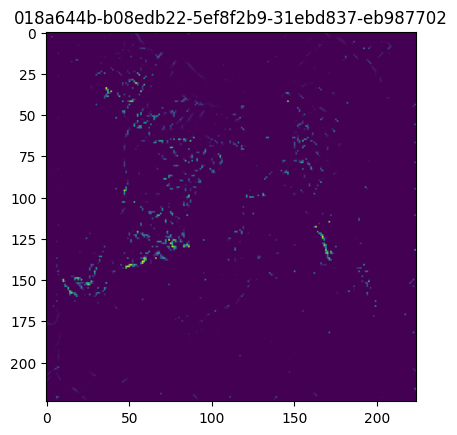

Step    1: Loss=0.117931 | Suff=0.005995 | Nec=0.029868 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.061221 | Suff=0.000446 | Nec=0.000126 | L1=0.521612 | TV=0.877351 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.059756 | Suff=0.000089 | Nec=0.000055 | L1=0.508058 | TV=0.887796 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.058763 | Suff=0.000017 | Nec=0.000033 | L1=0.498922 | TV=0.884558 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.057469 | Suff=0.000006 | Nec=0.000015 | L1=0.487110 | TV=0.874685 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.055459 | Suff=0.000003 | Nec=0.000007 | L1=0.469112 | TV=0.854226 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.052539 | Suff=0.000004 | Nec=0.000006 | L1=0.443481 | TV=0.818566 | Changed 

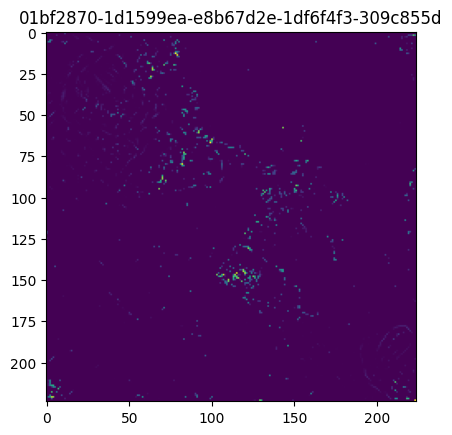

Step    1: Loss=0.153983 | Suff=0.102344 | Nec=0.005622 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.509512 | Suff=0.902233 | Nec=0.000000 | L1=0.494404 | TV=0.895477 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.058286 | Suff=0.001102 | Nec=0.000016 | L1=0.489602 | TV=0.876652 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.056972 | Suff=0.000144 | Nec=0.000022 | L1=0.481593 | TV=0.872983 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.055623 | Suff=0.000053 | Nec=0.000014 | L1=0.469785 | TV=0.861061 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.053610 | Suff=0.000027 | Nec=0.000006 | L1=0.451931 | TV=0.840044 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.050811 | Suff=0.000025 | Nec=0.000004 | L1=0.427219 | TV=0.807484 | Changed (

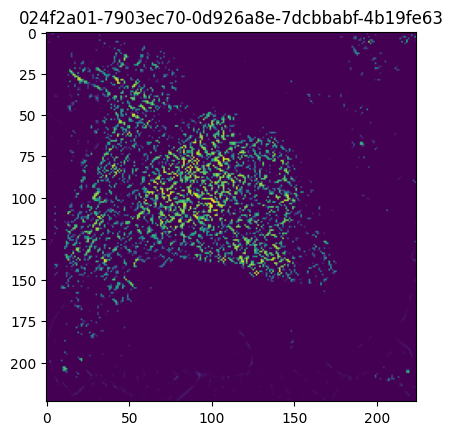

Step    1: Loss=0.114934 | Suff=0.000001 | Nec=0.029868 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.061348 | Suff=0.000004 | Nec=0.000001 | L1=0.523370 | TV=0.900811 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.060198 | Suff=0.000022 | Nec=0.000002 | L1=0.511366 | TV=0.904872 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.059371 | Suff=0.000026 | Nec=0.000002 | L1=0.503391 | TV=0.901767 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.058335 | Suff=0.000021 | Nec=0.000002 | L1=0.493810 | TV=0.894254 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.056803 | Suff=0.000012 | Nec=0.000003 | L1=0.479981 | TV=0.879732 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.054615 | Suff=0.000006 | Nec=0.000003 | L1=0.460616 | TV=0.854899 | Changed 

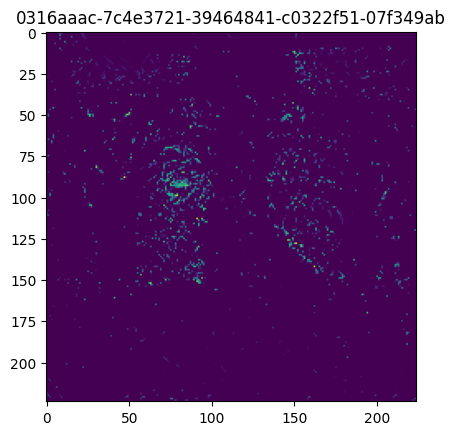

Step    1: Loss=0.114946 | Suff=0.000024 | Nec=0.029868 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.061652 | Suff=0.000007 | Nec=0.000410 | L1=0.525688 | TV=0.887390 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.060229 | Suff=0.000183 | Nec=0.000060 | L1=0.511298 | TV=0.897702 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.059269 | Suff=0.000048 | Nec=0.000023 | L1=0.502760 | TV=0.895778 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.058062 | Suff=0.000009 | Nec=0.000011 | L1=0.491750 | TV=0.887670 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.056081 | Suff=0.000003 | Nec=0.000008 | L1=0.473963 | TV=0.867949 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.053125 | Suff=0.000002 | Nec=0.000010 | L1=0.447990 | TV=0.831949 | Changed 

In [ ]:
file_paths = updated_df['full_path'].tolist()
for full_path in file_paths:
    # grab “foo.dcm” out of the whole path
    basename = os.path.basename(full_path)
    # strip only the “.dcm” off of that
    prefix   = os.path.splitext(basename)[0]

    # now prefix is unique for each file
    pil_img = load_dicom_as_pil(full_path)
    x       = test_transform(pil_img).unsqueeze(0).to(device)

    final_mask, mask_history, changed_class = optimize_mask(
        model,
        x,
        alpha=0.5,
        output_dir=output_dir,   # (if you want to save rather than plt.show)
        prefix=prefix
    )

    # if you want to inspect them inline:
    plt.imshow(final_mask.squeeze().cpu().numpy(), cmap='viridis')
    plt.title(prefix)
    plt.show()



'''
file_paths = updated_df['full_path'].tolist()
for full_path in file_paths:
    # nicer prefix:
    basename = os.path.basename(full_path)
    prefix   = os.path.splitext(basename)[0]

    # load + preprocess
    pil_img = load_dicom_as_pil(full_path)
    x       = test_transform(pil_img).unsqueeze(0).to(device)

    final_mask, mask_history, changed_class = optimize_mask(
        model,
        x,
        alpha=0.5,
        init_mask=torch.ones_like(x),
        output_dir=output_dir,
        prefix=prefix
    )


for full_path in file_paths:
    # derive a nice prefix from the filename, e.g. "patient123_slice45"
    # should just be the dicom number (before dcm)
    prefix = full_path.split('.')[0]

    # load + preprocess
    pil_img = load_dicom_as_pil(full_path)
    x       = test_transform(pil_img).unsqueeze(0).to(device)

    final_mask, mask_history, changed_class = optimize_mask(model, x, alpha=0.5, init_mask=torch.ones_like(x), output_dir=output_dir, prefix=prefix)
'''

# Testing on one image and then one mask

In [ ]:
example_path = updated_df.iloc[0]['full_path']
pil_img = load_dicom_as_pil(example_path)
x = test_transform(pil_img).unsqueeze(0).to(device)

## Optimize one mask

Step    1: Loss=0.129868 | Suff=0.000002 | Nec=0.029868 | L1=1.000000 | TV=0.000000 | Changed (keep): False | Changed (remove): True | LR=5.000000e-01
Step   10: Loss=0.115815 | Suff=0.981315 | Nec=0.000011 | L1=0.439733 | TV=0.718309 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   20: Loss=0.086106 | Suff=0.968558 | Nec=0.000019 | L1=0.340208 | TV=0.520663 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   30: Loss=0.056332 | Suff=0.972336 | Nec=0.000018 | L1=0.228181 | TV=0.334957 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   40: Loss=0.033111 | Suff=0.966931 | Nec=0.000025 | L1=0.136483 | TV=0.194375 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=0.018490 | Suff=0.919614 | Nec=0.000013 | L1=0.075946 | TV=0.108821 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   60: Loss=0.011815 | Suff=0.924758 | Nec=0.000025 | L1=0.045557 | TV=0.072342 | Changed (keep

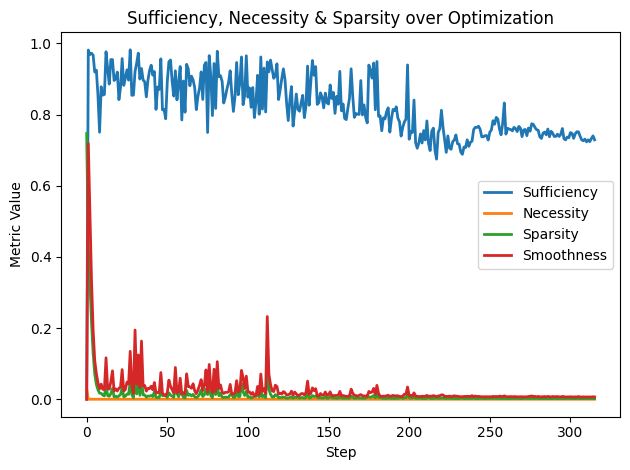

In [ ]:
final_mask, mask_history, changed_class = optimize_mask(model, x, alpha=0.5, init_mask=torch.ones_like(x), output_dir=output_dir, prefix=None)


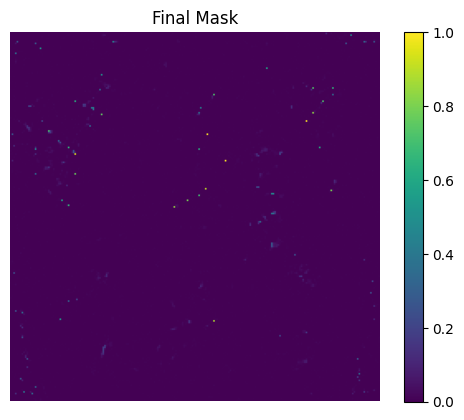

In [ ]:
plt.imshow(final_mask.squeeze().cpu().numpy(), cmap='viridis')
plt.title("Final Mask")
plt.colorbar()
plt.axis('off')
plt.show()

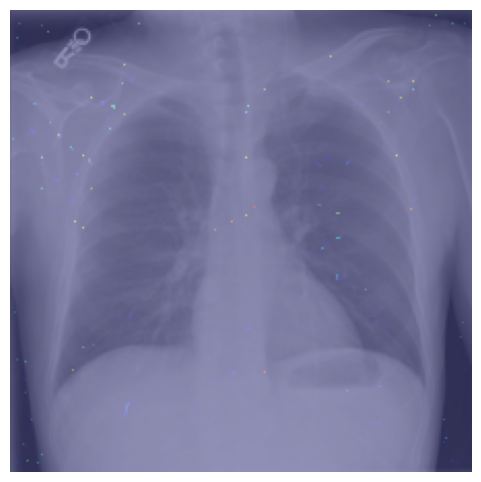

In [ ]:
# 1. Get your mask as a 2D numpy array
mask_np = final_mask.detach().cpu().squeeze().numpy()   # shape (H,W)

# 2. Get the exact image that was fed to the model
#    (i.e. after resize but before normalize)
# If your test_transform is something like Compose([Resize, ToTensor, Normalize]),
# you can manually re‐apply only the Resize + ToTensor:
from torchvision import transforms
resize_only = transforms.Compose([
    transforms.Resize((mask_np.shape[0], mask_np.shape[1])),
    transforms.ToTensor()
])
img_tensor = resize_only(pil_img)           # shape (C,H,W), values in [0,1]
img_np     = img_tensor.squeeze().numpy()   # shape (H,W)

# 3. Plot them together
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(img_np, cmap='gray', vmin=0, vmax=1)
plt.imshow(mask_np, cmap='jet', alpha=0.3)
plt.axis('off')
plt.show()


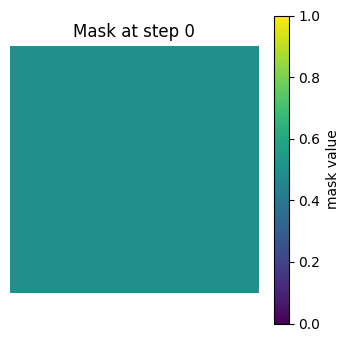

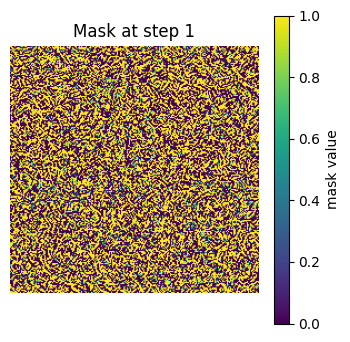

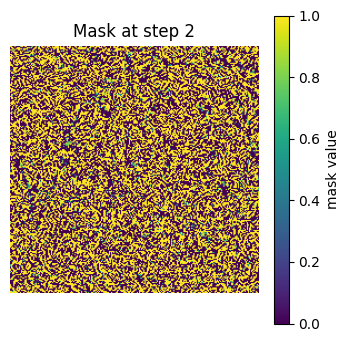

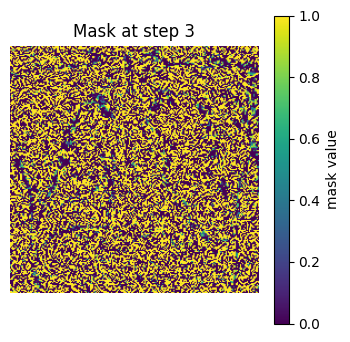

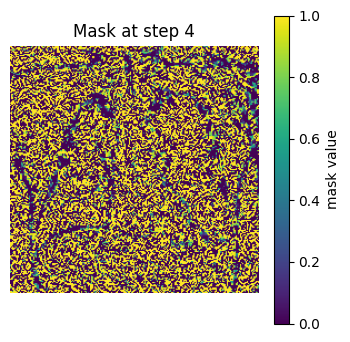

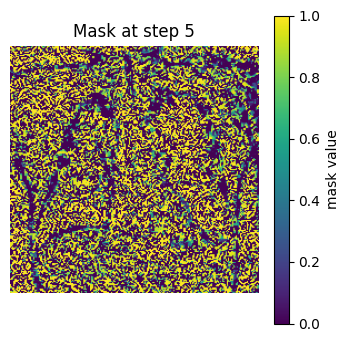

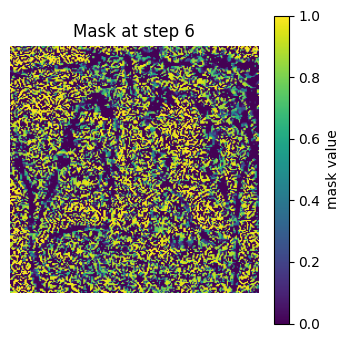

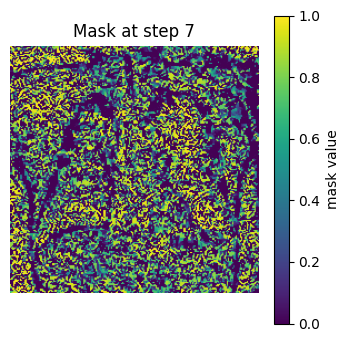

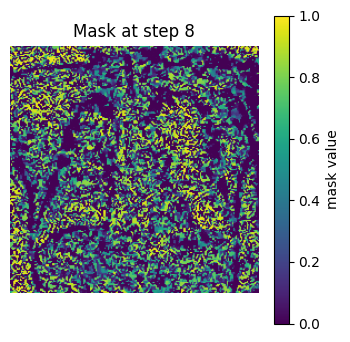

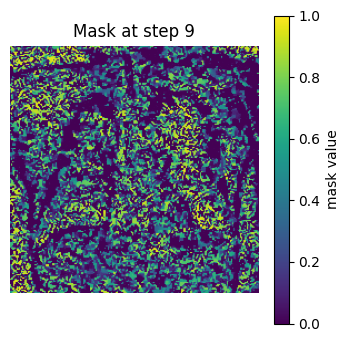

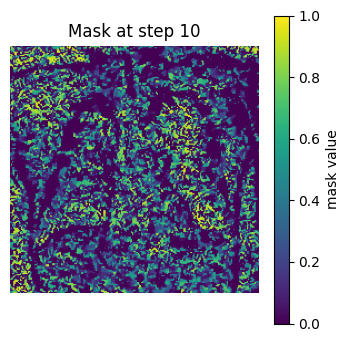

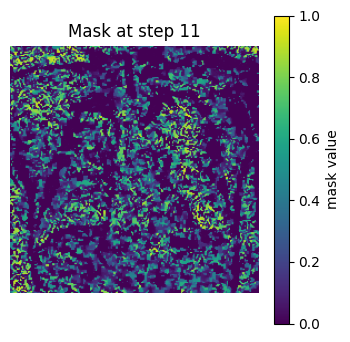

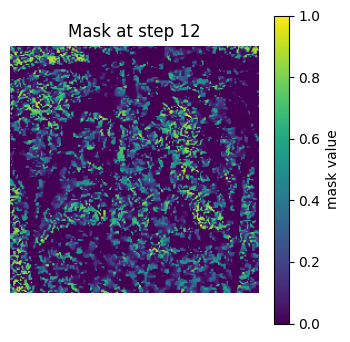

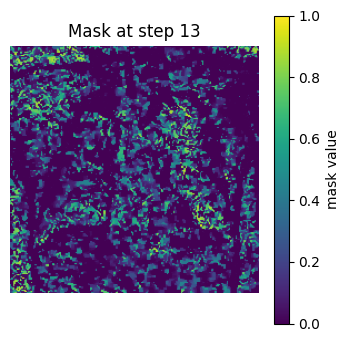

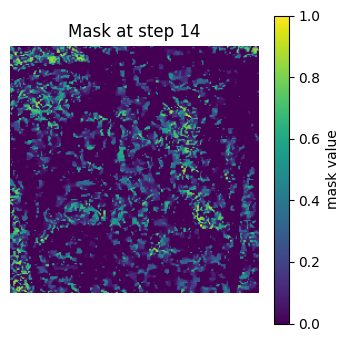

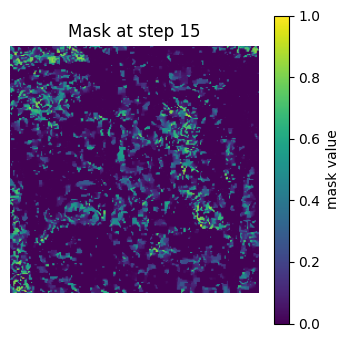

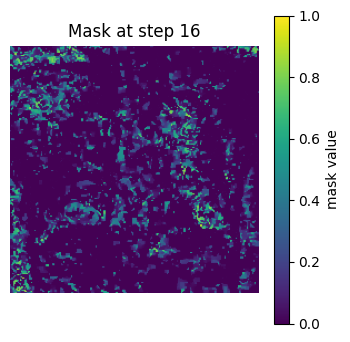

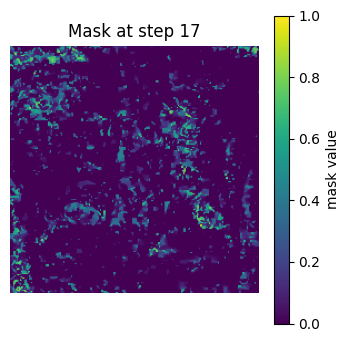

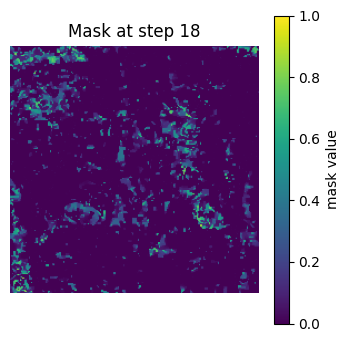

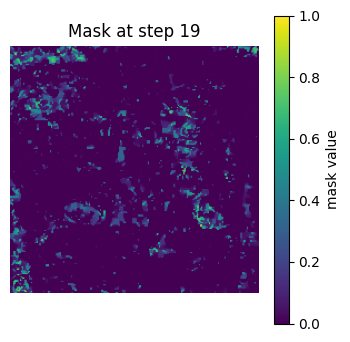

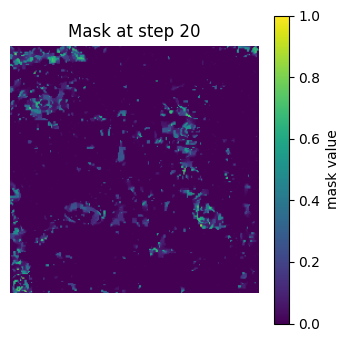

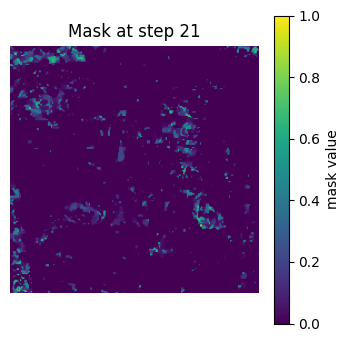

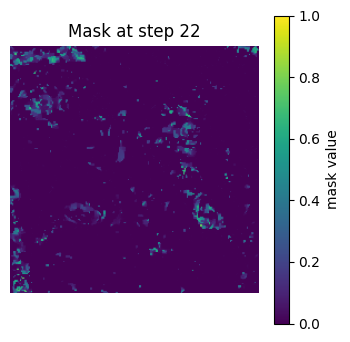

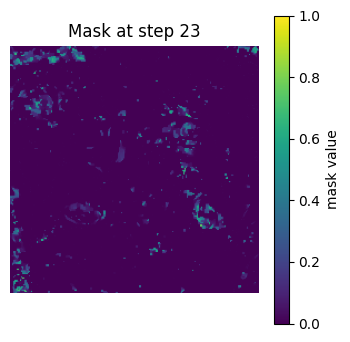

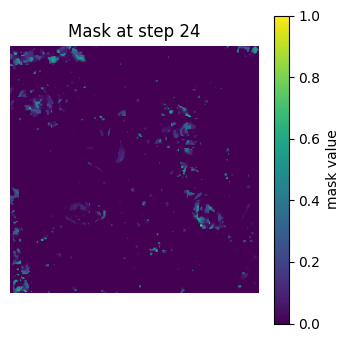

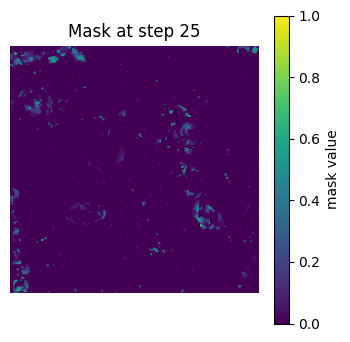

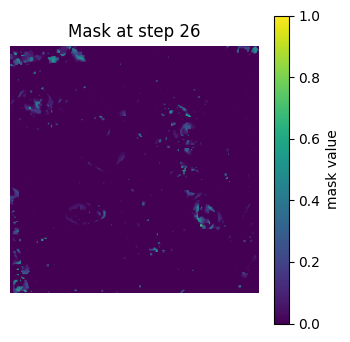

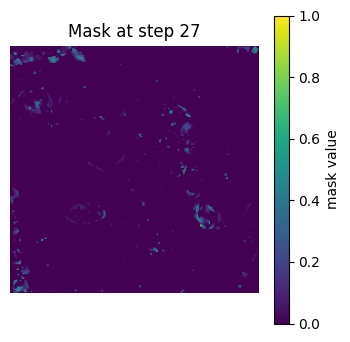

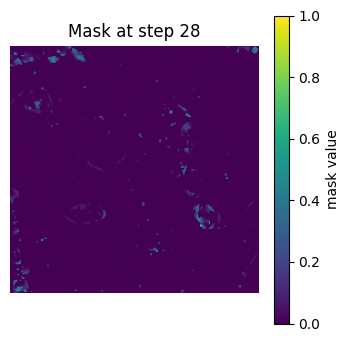

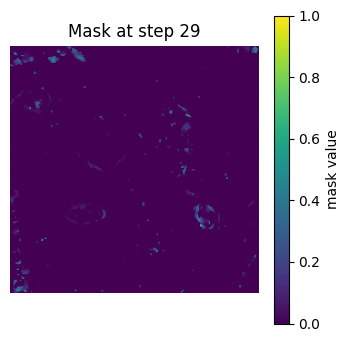

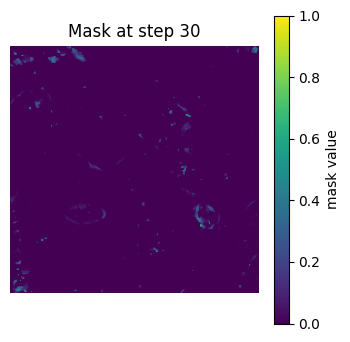

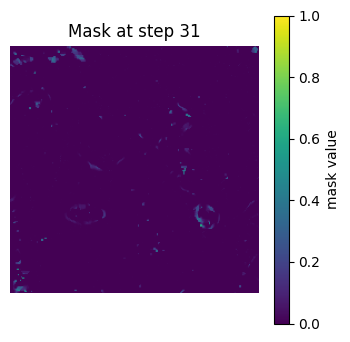

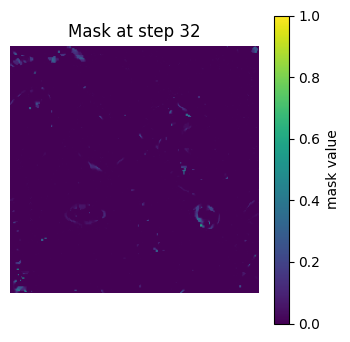

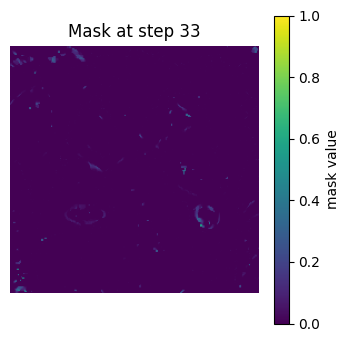

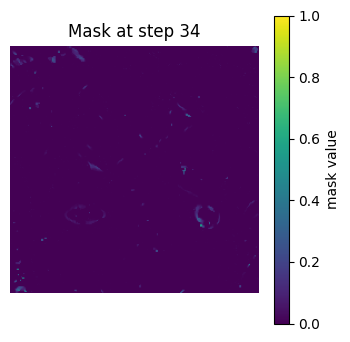

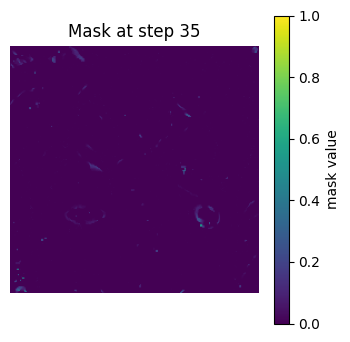

In [ ]:
import matplotlib.pyplot as plt

for step, m in enumerate(mask_history):
    m_np = m.detach().cpu().squeeze().numpy()   # shape (H,W)
    plt.figure(figsize=(4,4))
    plt.title(f"Mask at step {step}")
    plt.imshow(m_np, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='mask value')
    plt.axis('off')
    plt.show()
